# Brown Bag Seminar: Genetic Algorithm

By Ronie Arauco

## 1. The Knapsack Problem

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Knapsack.svg/1200px-Knapsack.svg.png" alt="drawing" width="400"/></center>

Let's say you want to go on a trip and the only thing you can take is a knapsack with a capacity of **N** kg. Your goal is to choose the items with the highest possible value and whose weights do not exceed the limit of the knapsack.

In [ ]:
!pip install plotnine==0.8.0

In [ ]:
import numpy as np
import random
import time
from copy import deepcopy
from plotnine import ggplot, aes, geom_line, theme_bw, labs, theme, scale_y_continuous
from mizani.formatters import scientific_format

We can change values and prove different scenarios.

*   **max_wt**: Maximum capacity of knapsack
*   **max_val**: Maximum value an element can have
*   **n**: Total number of elements
*   **val**: Vector that contains all values
*   **Wt**: Vector that contains all weights



### 1.1. Genetic Algorithm

Individual class must be created. Individual have genetic operators such as crossover and mutation.

In [1]:
class Individual:   
  def __init__(self, chromosome):
    self.chromosome = chromosome[:]
    self.fitness = -1

  def crossover_onepoint(self, other):
    c = random.randrange(len(self.chromosome))
    ind1 = \
      Individual(self.chromosome[:c] + other.chromosome[c:])
    ind2 = \
      Individual(other.chromosome[:c] + self.chromosome[c:])
    return [ind1, ind2]

  def crossover_uniform(self, other):
    chromosome1 = []
    chromosome2 = []
    for i in range(len(self.chromosome)):
      if random.uniform(0, 1) < 0.5:
        chromosome1.append(self.chromosome[i])
        chromosome2.append(other.chromosome[i])
      else:
        chromosome1.append(other.chromosome[i])
        chromosome2.append(self.chromosome[i])
    ind1 = Individual(chromosome1)
    ind2 = Individual(chromosome2)
    return [ind1, ind2]

  def mutate_position(self):
    mutated_chromosome = deepcopy(self.chromosome)
    mut_gene = random.randrange(0, len(mutated_chromosome))
    mutated_chromosome[mut_gene] = 1 if mutated_chromosome[mut_gene] == 0 else 0
    return Individual(mutated_chromosome)

  def mutate_swap(self):
    mutated_chromosome = deepcopy(self.chromosome)
    mut_gen1 = random.randrange(0, len(mutated_chromosome))
    mut_gen2 = random.randrange(0, len(mutated_chromosome))
    temp = mutated_chromosome[mut_gen1]
    mutated_chromosome[mut_gen1] = mutated_chromosome[mut_gen2]
    mutated_chromosome[mut_gen2] = temp
    return Individual(mutated_chromosome)

Random initialization of population is recommended. The representation of the chromosome is binary. That is, 1 represents an element chosen and 0 not chosen.

In [ ]:
def init_population(pop_number, chromosome_size):
  """
  population = []
  for i = 0 to pop_number.length
    new_chromosome = []
    for j = 0 to chromosome.length
      if random.uniform(0, 1) > 0.5
        new_chromosome[j] = 1
      else
        new_chromosome[j] = 0
    population[i] = Individual(new_chromosome)
  """
  return population

Fitness function is the sum of all element values that can fit in knapsack.

In [ ]:
def knapsack_value(chromosome, values, weights, max_weight):
  """
  fitness = 0
  cumm_weight = 0
  for i = 0 to chromosome.length
    if chromosome[i] = 1
      fitness = fitness + values[i]
      cumm_weight = cumm_weight + weights[i]
      if cumm_weight > max_weight
        fitness = 0
        break
  """
  return fitness

def evaluate_population(population, fitness_fn, values, weights, max_weight):
  popsize = len(population)
  for i in range(popsize):
    if population[i].fitness == -1:
      population[i].fitness = \
        fitness_fn(population[i].chromosome, values, weights, max_weight)

Two selection methods were implemented: Roulette Wheel and Tournament.

In [ ]:
def select_parents_roulette(population):
  popsize = len(population)
  sumfitness = sum([indiv.fitness for indiv in population])
  pickfitness = random.uniform(0, sumfitness)
  cumfitness = 0
  iparent1 = random.randint(0, popsize - 1)
  for i in range(popsize):
    cumfitness += population[i].fitness
    if cumfitness > pickfitness: 
      iparent1 = i
      break
  sumfitness = sumfitness - population[iparent1].fitness
  pickfitness = random.uniform(0, sumfitness)
  cumfitness = 0
  iparent2 = random.randint(0, popsize - 1)
  for i in range(popsize):
    if i == iparent1: continue
    cumfitness += population[i].fitness
    if cumfitness > pickfitness:
      iparent2 = i
      break        
  return (population[iparent1], population[iparent2])

def select_parents_tournament(population, size_tournament):
  list_indiv=[]
  x1 = np.random.permutation(len(population))
  y1 = x1[0:size_tournament]
  for i in range(size_tournament):
    list_indiv.append(population[y1[i]].fitness)
  iparent1 = np.argmax(list_indiv)
  x2 = np.delete(x1, iparent1)
  x2 = np.random.permutation(x2)
  list_indiv = []
  y2 = x2[0:size_tournament]
  for i in range(size_tournament):
    list_indiv.append(population[y2[i]].fitness)
  iparent2 = np.argmax(list_indiv)
  return (population[x1[iparent1]],population[x2[iparent2]])

Survivors are the best individuals of the offspring according to the fitness function.

In [ ]:
def select_survivors(population, offspring_population, numsurvivors):
  next_population = []
  population.extend(offspring_population)
  isurvivors = \
    sorted(range(len(population)), key=lambda i: population[i].fitness, \
      reverse=True)[:numsurvivors]
  for i in range(numsurvivors):
    next_population.append(population[isurvivors[i]])
  return next_population

Complete flow is implemented: parents selection, crossover, mutation and survivors selection.

In [ ]:
def genetic_algorithm(population, fitness_fn, values, weights, max_weight, \
  ngen, metodoSeleccion, size_tournament, pmut, crossover, mutation):

  popsize = len(population)
  evaluate_population(population, fitness_fn, values, weights, max_weight)
  ibest = \
    sorted(range(len(population)), key=lambda i: population[i].fitness, \
      reverse=True)[:1]
  bestfitness = [population[ibest[0]].fitness]
  print(f"Initial population, best_fitness = {population[ibest[0]].fitness}")
  
  for g in range(ngen):
    mating_pool = []
    if metodoSeleccion=="roulette":
      for i in range(int(popsize/2)):
        mating_pool.append(select_parents_roulette(population)) 
    elif metodoSeleccion=="tournament" :
      for i in range(int(popsize/2)):
        mating_pool.append(select_parents_tournament(population, \
          size_tournament)) 

    offspring_population = []
    for i in range(len(mating_pool)): 
      if crossover == "onepoint":
        offspring_population.extend( \
          mating_pool[i][0].crossover_onepoint(mating_pool[i][1]))
      elif crossover == "uniform":
        offspring_population.extend( \
          mating_pool[i][0].crossover_uniform(mating_pool[i][1]))

    for i in range(len(offspring_population)):
      if random.uniform(0, 1) < pmut: 
        if mutation == "position":
          offspring_population[i] = offspring_population[i].mutate_position()
        elif mutation == "swap":
          offspring_population[i] = offspring_population[i].mutate_swap()

    evaluate_population(offspring_population, fitness_fn, values, weights, \
      max_weight)
    
    population = select_survivors(population, offspring_population, popsize)

    ibest = \
      sorted(range(len(population)), key=lambda i: population[i].fitness, \
        reverse=True)[:1]
    bestfitness.append(population[ibest[0]].fitness)
    
    best_election = population[ibest[0]].chromosome
    print(f"Generation {g}, Best individual = {best_election} (fitness = {population[ibest[0]].fitness})")

  return population[ibest[0]], bestfitness

We can change values and prove different scenarios.

*   **max_wt**: Maximum capacity of knapsack
*   **max_val**: Maximum value an element can have
*   **n**: Total number of elements
*   **val**: Vector that contains all values
*   **Wt**: Vector that contains all weights

In [ ]:
n = 10
num_individuals = n * 5 
max_wt, max_val = 3000, 200
wt = np.random.randint(20, max_wt * 0.5, n)
val = np.random.randint(20, max_val, n)

population = init_population(num_individuals, n)

fitness_fn = knapsack_value

ngen = 20
pmut = 0.1

selection_method=["roulette", "tournament"]
size_tournament = int(5 * num_individuals / 100)

crossover = ["onepoint", "uniform"]
mutation = ["position", "swap"]

print("======= Problem context =======")
print(f"Weights: {wt} \n Values: {val}", end="\n\n")

print("====== Genetic algorithm ======")
best_ind, bestfitness = \
  genetic_algorithm(population, fitness_fn, val, wt, max_wt, ngen,
    selection_method[1], size_tournament, pmut, crossover[0], mutation[0])

======= Problem context =======
Weights: [ 576  329  249  391  660  353 1292  553  476  740] 
 Values: [ 46 166  32 181  73 144 164 108  58  93]

====== Genetic algorithm ======
Initial population, best_fitness = 701
Generation 0, Best individual = [0, 1, 0, 1, 1, 1, 0, 0, 1, 1] (fitness = 715)
Generation 1, Best individual = [0, 1, 0, 1, 1, 1, 0, 0, 1, 1] (fitness = 715)
Generation 2, Best individual = [0, 1, 0, 1, 1, 1, 0, 1, 1, 0] (fitness = 730)
Generation 3, Best individual = [0, 1, 0, 1, 1, 1, 0, 1, 1, 0] (fitness = 730)
Generation 4, Best individual = [0, 1, 0, 1, 1, 1, 0, 1, 1, 0] (fitness = 730)
Generation 5, Best individual = [0, 1, 0, 1, 1, 1, 0, 1, 1, 0] (fitness = 730)
Generation 6, Best individual = [0, 1, 0, 1, 1, 1, 0, 1, 1, 0] (fitness = 730)
Generation 7, Best individual = [0, 1, 0, 1, 1, 1, 0, 1, 1, 0] (fitness = 730)
Generation 8, Best individual = [0, 1, 0, 1, 1, 1, 0, 1, 1, 0] (fitness = 730)
Generation 9, Best individual = [0, 1, 0, 1, 1, 1, 0, 1, 1, 0] (fitness 

Fitness improves throughout generations.



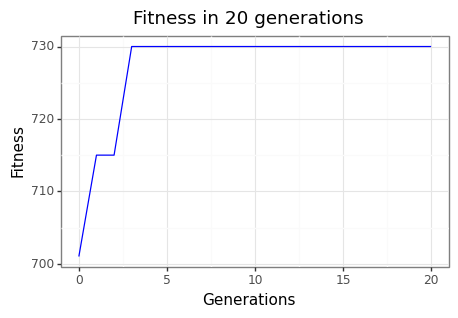

<ggplot: (8782139306793)>

In [ ]:
(
  ggplot(aes(range(ngen + 1), bestfitness)) + \
  geom_line(colour="blue") + \
  theme_bw() + \
  labs(title=f"Fitness in {ngen} generations", x="Generations", y="Fitness") + \
  theme(figure_size=(5, 3))
)